In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from scipy import stats
import seaborn as sns
from scipy.linalg import sqrtm
from sklearn.metrics import mean_squared_error
from math import sqrt

# Load Data

In [94]:
reviews = pd.read_csv('/kaggle/input/tokyosentimentanalysisdata/Tokyo SentimentAnalysis reviews.csv')
reviews.head(3)

,listing_id,id,date,reviewer_id,reviewer_name,comments,language,polarity
0,972776126849275730,1019245689733969802,2023-11-07,101396772,May,The place is so convenient! 👌,en,0.0000
1,972776126849275730,1025755520393278974,2023-11-16,263928959,Sonny,Stayed from November - and all we can say ...,en,0.9270
2,972776126849275730,1030776093828956890,2023-11-22,37279714,Harvey,Our stay at J-Court Oshiage Deluxe Room was ex...,en,0.8687


In [95]:
df_rec = reviews[['reviewer_id', 'listing_id', 'polarity']]
df_rec.nunique()

reviewer_id    2437
listing_id      981
polarity       1127
dtype: int64

In [96]:
df_rec

,reviewer_id,listing_id,polarity
0,101396772,972776126849275730,0.0000
1,263928959,972776126849275730,0.9270
2,37279714,972776126849275730,0.8687
3,97513213,972776126849275730,0.9217
4,544959463,972776126849275730,0.4215
...,...,...,...
2504,12232828,1045471787225732076,0.6369
2505,551466066,1045476502379913097,0.9409
2506,477583600,1046744009575818573,0.8550
2507,147981618,1041968407997091281,0.5719


# Creating the Recommendation engine

In [97]:
# create utility matrix

matrix = df_rec.pivot_table(index='reviewer_id', columns='listing_id', values='polarity')
matrix.head()

listing_id,965803227717685421,965826016318638702,966177816995572151,966188830851922071,966297711861030985,966298001587010678,966343810145713383,966374626571650275,966416736126005357,966497051561983022,...,1042326442362460912,1043371784987516991,1043956204661532583,1044030722855149766,1044493815124780527,1044545397593809861,1045471787225732076,1045476502379913097,1046744009575818573,1049804254823201078
reviewer_id,,,,,,,,,,,,,,,,,,,,,
23563,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
252967,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
352488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
366630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
395384,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [98]:
# keep track of reviewers (users) and listings (items)

userrows = list(matrix.index)
users_index = {userrows[i]: i for i in range(len(userrows))}

itemcols = list(matrix.columns)
items_index = {itemcols[i]: i for i in range(len(itemcols))}

In [99]:
from scipy.sparse.linalg import svds

# this function also incorporates creating the utility matrix and keep track of reviewer and listing IDs

def recommend_predictions(df_rec, k):
    """
    :param df_rec: dataframe with polarity values for known reviewer/listing pairs
    :param k: number of features to keep for SVD

    returns the dataframe with predicted polarity values for all (user,item) pairs
    """
    # get utility matrix
    util_mat = df_rec.pivot_table(index='reviewer_id', columns='listing_id', values='polarity')

    # keep track of reviewers and listings
    reviewer_rows = list(util_mat.index)
    reviewer_index = {reviewer_rows[i]: i for i in range(len(reviewer_rows))}
    listing_cols = list(util_mat.columns)
    listing_index = {listing_cols[i]: i for i in range(len(listing_cols))}

    # mask NaN and remove means
    mask = np.isnan(util_mat)
    masked_arr = np.ma.masked_array(util_mat, mask)
    item_means = np.mean(masked_arr, axis=0) 
    util_mat = masked_arr.filled(item_means)
    means = np.tile(item_means, (util_mat.shape[0],1))
    util_mat_demeaned = util_mat - means

    # run SVD
    U, sigma, Vt = svds(util_mat_demeaned, k = k)
    sigma = np.diag(sigma)  
    all_predicted_polarity = np.dot(np.dot(U, sigma), Vt) + means

    return all_predicted_polarity, reviewer_index, listing_index

In [100]:
svdout,_,_ = recommend_predictions(df_rec, k=50)

In [101]:
this_pred = [] #to store the predicted ratings
for i, row in df_rec.iterrows():
    user = row['reviewer_id']
    item = row['listing_id']
    
    try:
        u_index = users_index[user]
        if item in items_index:
            i_index = items_index[item]
            pred_rating = pred[u_index, i_index]
        else:
            pred_rating = np.mean(svdout[u_index, :])
        this_pred.append(pred_rating)
        
    except:
        print('error with user', user, 'at index', i)

In [102]:
rmse = sqrt(mean_squared_error(df_rec['polarity'], this_pred))
print(rmse)

0.3053173621157866


In [103]:
# try different values of k

no_of_features = [70, 100, 120, 150]
rmse= []

for k in no_of_features:
    pred_out, _, _ = recommend_predictions(df_rec, k=k)
    
    this_pred = [] #to store the predicted ratings
    for i, row in df_rec.iterrows():
        user = row['reviewer_id']
        item = row['listing_id']

        try:
            u_index = users_index[user]
            if item in items_index:
                i_index = items_index[item]
                pred_rating = pred_out[u_index, i_index]
            else:
                pred_rating = np.mean(svdout[u_index, :])
            this_pred.append(pred_rating)

        except:
            print('error with user', user, 'at index', i)
            continue

    rmse_i = sqrt(mean_squared_error(df_rec['polarity'], this_pred))
    rmse.append(rmse_i)
    
    print(k, rmse_i)

70 0.3053173621157866
100 0.3053173621157866
120 0.3053173621157866
150 0.3053162610739216


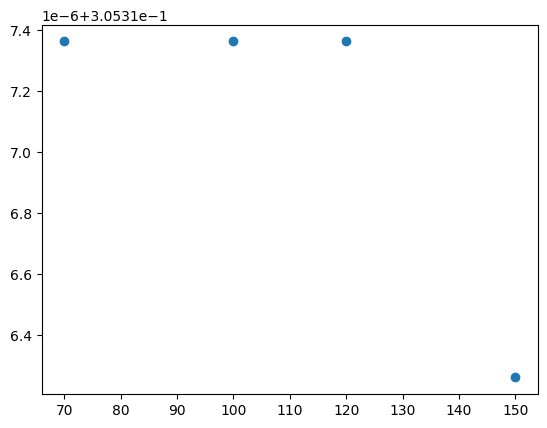

In [104]:
plt.scatter(no_of_features, rmse);

# Get top recommendations for a user

In [105]:
listing_id_array = df_rec['listing_id'].unique()

def get_recommendations(predMat, reviewer, N):
    """
    predMat: predicted matrix, svdout
    reviewer: selected reviewer_id
    N: top N recommendations
    
    return top N recommendations for specified user
    """
    u_index = users_index[reviewer]
    item_i = [items_index[listing_id_array[i]] for i in range(len(listing_id_array))]
    
    pred_user = [predMat[u_index, i_index] for i_index in item_i]
    
    d = {'listing_id': listing_id_array, 'predicted_polarity': pred_user}
    user_rec = pd.DataFrame(data=d)
    user_rec.sort_values(by=['predicted_polarity'], ascending=False, inplace=True)
    user_rec.reset_index(inplace=True, drop=True)
    
    return user_rec[:N]

In [106]:
# using mat from SVD method

user_rec = get_recommendations(svdout, df_rec['reviewer_id'][0], 10)
user_rec.style.bar(subset=['predicted_polarity'], align='mid', color=['#d65f5f', '#5fba7d'])

,listing_id,predicted_polarity
0,999558475637380758,0.994300
1,982207500628771912,0.993300
2,1020458162551606928,0.991900
3,1008236877424535235,0.991600
4,1031563519543611072,0.991400
5,1028573316362802126,0.988300
6,995337132883654692,0.988200
7,1020988089024367863,0.988000
8,985972190048477039,0.987800
9,1003489071301964027,0.987200
